# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df_fake = pd.read_csv("/content/Fake.csv")
df_true = pd.read_csv("/content/True.csv")

In [3]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Inserting a column "class" as target feature

In [5]:
df_fake["class"] = 0
df_true["class"] = 1

In [7]:
df_true.head()

,title,text,subject,date,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


## Merging True and Fake Dataframes

In [6]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


## Removing unnecessary columns

In [8]:
df = df_merge.drop(["title", "subject","date"], axis = 1)

In [9]:
#checking null values
df.isnull().sum()

,0
text,0
class,0


In [10]:
#Random shuffling the dataframe to see different classes
df = df.sample(frac = 1)

In [11]:
df.head()

,text,class
15948,Officials allegedly affiliated with the United...,0
2053,PHOENIX (Reuters) - U.S. President Donald Trum...,1
10517,DETROIT (Reuters) - Former U.S. presidential c...,1
137,WASHINGTON (Reuters) - President Donald Trump ...,1
7359,WASHINGTON (Reuters) - U.S. President Barack O...,1


In [12]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [13]:
df.head()

,text,class
0,Officials allegedly affiliated with the United...,0
1,PHOENIX (Reuters) - U.S. President Donald Trum...,1
2,DETROIT (Reuters) - Former U.S. presidential c...,1
3,WASHINGTON (Reuters) - President Donald Trump ...,1
4,WASHINGTON (Reuters) - U.S. President Barack O...,1


# Function for text preprocessing

In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [17]:
def clean_text(text):
    # remove urls
    text = re.sub(r"http\S+|www\S+", "", str(text))
    # remove html tags
    text = re.sub(r"<.*?>", "", text)
    # remove punctuation & numbers
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # lowercase
    text = text.lower()
    # tokenize
    tokens = text.split()
    # remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


In [18]:
df["clean_text"] = df["text"].apply(clean_text)

In [20]:
df.head()

,text,class,clean_text
0,Officials allegedly affiliated with the United...,0,official allegedly affiliated united state par...
1,PHOENIX (Reuters) - U.S. President Donald Trum...,1,phoenix reuters u president donald trump expre...
2,DETROIT (Reuters) - Former U.S. presidential c...,1,detroit reuters former u presidential candidat...
3,WASHINGTON (Reuters) - President Donald Trump ...,1,washington reuters president donald trump call...
4,WASHINGTON (Reuters) - U.S. President Barack O...,1,washington reuters u president barack obama ov...


## Defining dependent and independent variables

In [19]:
x = df["clean_text"]
y = df["class"]

# Split the data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


# TF-IDF Vectorization

In [23]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

# Logistic Regression Model

In [24]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)

LogisticRegression()

In [25]:
pred_lr=LR.predict(xv_test)

In [26]:
#accuracy score
LR.score(xv_test, y_test)

0.987305122494432

In [27]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# SVM Model

In [28]:
svm = LinearSVC()
svm.fit(xv_train, y_train)
y_pred_svm = svm.predict(xv_test)

In [29]:
#accuracy score
svm.score(xv_test, y_test)

0.9939866369710467

# Evaluation

In [31]:
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

Logistic Regression:
Accuracy: 0.987305122494432
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [32]:
print("\nSVM:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM:
Accuracy: 0.9939866369710467
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4696
           1       0.99      1.00      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



# Confusion Matrix

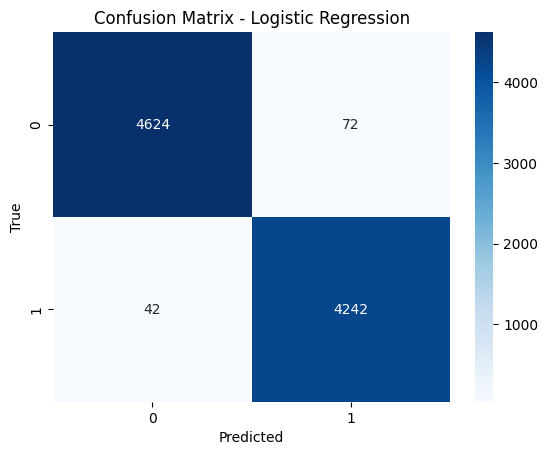

In [34]:
# (Logistic Regression)
cm = confusion_matrix(y_test, pred_lr, labels=LR.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LR.classes_, yticklabels=LR.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# **Word Cloud**

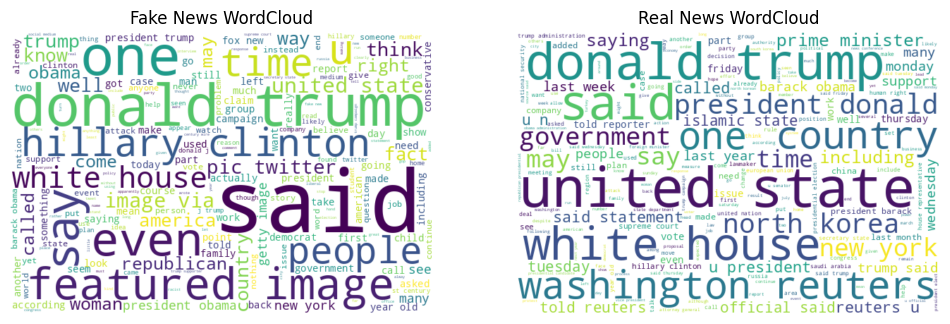

In [36]:
fake_text = " ".join(df[df["class"]==0]["clean_text"])
real_text = " ".join(df[df["class"]==1]["clean_text"])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wc_fake = WordCloud(width=600, height=400, background_color="white").generate(fake_text)
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Fake News WordCloud")

plt.subplot(1,2,2)
wc_real = WordCloud(width=600, height=400, background_color="white").generate(real_text)
plt.imshow(wc_real, interpolation="bilinear")
plt.axis("off")
plt.title("Real News WordCloud")
plt.show()